# Introduction

Fred Etter - March 2019  

This notebook uses data from a Kaggle competition to predict if a customer will buy a product from Banco Santander during a typical transaction.  There are a total of 200,000 rows of customer transactions along with the binary outcome of whether they made a purchase or not.  There are 200 columns, or 200 features, to use as inputs to each of the models that are presented.  

The workflow in this notebook is as follows:
- import data
- clean data  
- data exploration  
- modeling and evaluation
- conclusion and discussion  


In [1]:
# Import necessary modules
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
import sklearn
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Import and clean the data  
In this section, the data is imported and cleaned.

Import the data from a csv file; then print the number of rows and columns of the data; then show the first 5 lines of the dataframe.

In [2]:
df = pd.read_csv(r"C:\Users\Fred\Documents\PythonDirectory\Unit 3\train_san.csv")
print(df.shape)
df.head()

(200000, 202)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


As you see, we have 200,000 rows and 202 columns.  All of the feature data are float numbers.  We can drop the ID_code later because it is irrevelant.  The var_1, var_2, etc are the column names given in the orginal dataset.  These features have not been specifically defined in Kaggle.  They are anonymized features that have been captured during customer transactions.

Next, we'll print the sum of the 'target' column which is the number of all of the rows where the customer bought a product.  Then we calculate the buy ratio.  As you can see here, a customer bought something about 10% of the time.

In [3]:
df['target'].sum()


20098

In [4]:
# print the sume of the target column
df['target'].sum()

# divide the target sum by the total number of rows
print("Customers average buy ratio, {}".format(df['target'].sum()/len(df['target'])))

Customers average buy ratio, 0.10049


Now we know we have a highly imbalanced dataset; 10% are 'buy' transactions, 90% are 'not buy' transactions.  In order to capture this imbalance we will use following technique:
- we will randomly remove most of the 'not buy' rows so the number of 'buy' and 'not buy' rows are even.  

Next, let's look at some of the data types in our dataset and check for NaN values.

In [5]:
df.dtypes.head()

ID_code     object
target       int64
var_0      float64
var_1      float64
var_2      float64
dtype: object

We see that the 'target' data type is an integer which is what we'll need for the machine learning algorithms.  We have float values for the columns - which is what we want - and an 'ID_code' that is an object (we'll delete this column later).

In [6]:
df.isnull().sum().sum()

0

Perfect, no cleaning necessary for NaN values.

Drop the ID_code column since it is a string and irrelevant to making a buy or no_buy prediction.  Also, drop a random sample of 140,000 rows to account for hardware / memory limitations.

In [7]:
# drop ID_code column
df.drop(['ID_code'], axis=1, inplace=True)

# drop a random sample of 140,000 rows
df.drop(df.sample(140000).index, inplace=True)

Look at the number of rows of the data to make sure we dropped correct amount and then shuffle the data randomly to prepare data for modeling.

In [8]:
df.shape[0]
df = df.sample(frac=1)

Take another look at the data to see random shuffled rows.

In [9]:
df.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
121222,0,6.2625,-4.0417,10.3170,6.5514,9.3498,4.6650,7.3157,16.6142,5.4739,...,-1.0860,14.8758,1.4119,4.3648,16.0949,-1.4010,9.9535,7.6969,14.3498,3.0516
80409,0,10.0538,-5.9506,13.0542,7.1233,12.2353,-4.7589,5.9848,15.3332,-0.6194,...,0.3478,10.7834,2.1001,8.6824,17.2169,1.0745,-0.9435,9.3735,14.9525,-5.8006
130588,0,10.2652,-5.5851,14.9789,4.1652,10.5944,0.9731,4.1216,15.8028,4.0675,...,6.2877,3.1514,4.0319,1.8087,22.8338,0.0807,-3.0639,9.9414,22.6460,4.4980
195955,0,7.5227,-4.2115,10.3201,7.4156,13.1854,-3.6333,6.1676,20.6219,-4.3249,...,-2.2480,9.2659,3.7667,3.4118,17.1146,2.7657,-1.0638,7.7005,15.7660,-0.9671
185250,0,10.6353,0.4767,12.3861,7.7296,11.9525,-4.3938,5.6577,15.4312,0.4549,...,6.6133,4.4580,0.9943,-3.5959,18.0867,0.7945,7.5393,9.7650,15.2926,9.1039


At this point our data looks clean and ready to start exploring in more detail to look for features that might be better predictors for the target data.  We can use the pairplot and the heatmap functionality to begin this analysis.

## Data Exploration  
First, let's look at the correlation between the target and the features.

In [10]:
# use absolute value
np.absolute(df.corr().unstack().sort_values().drop_duplicates())

target   var_81     0.081106
         var_139    0.074793
         var_174    0.065394
         var_146    0.064262
var_12   target     0.063514
target   var_76     0.060731
         var_198    0.060726
         var_80     0.060156
var_13   target     0.059889
target   var_169    0.057564
var_21   target     0.056874
target   var_166    0.054601
         var_165    0.053547
var_148  target     0.052916
var_33   target     0.052389
var_34   target     0.051848
target   var_154    0.051627
         var_44     0.049837
         var_115    0.048453
var_86   target     0.048441
target   var_9      0.048154
         var_108    0.046374
         var_127    0.045344
var_107  target     0.045236
var_92   target     0.045187
target   var_109    0.045108
         var_192    0.044814
         var_149    0.043943
         var_122    0.041342
var_123  target     0.040643
                      ...   
var_32   target     0.036863
target   var_162    0.037109
var_71   target     0.037564
target   var_8

Next, we'll look at the pairplot for the top 10 features as determined by the correlations found in the previous step.

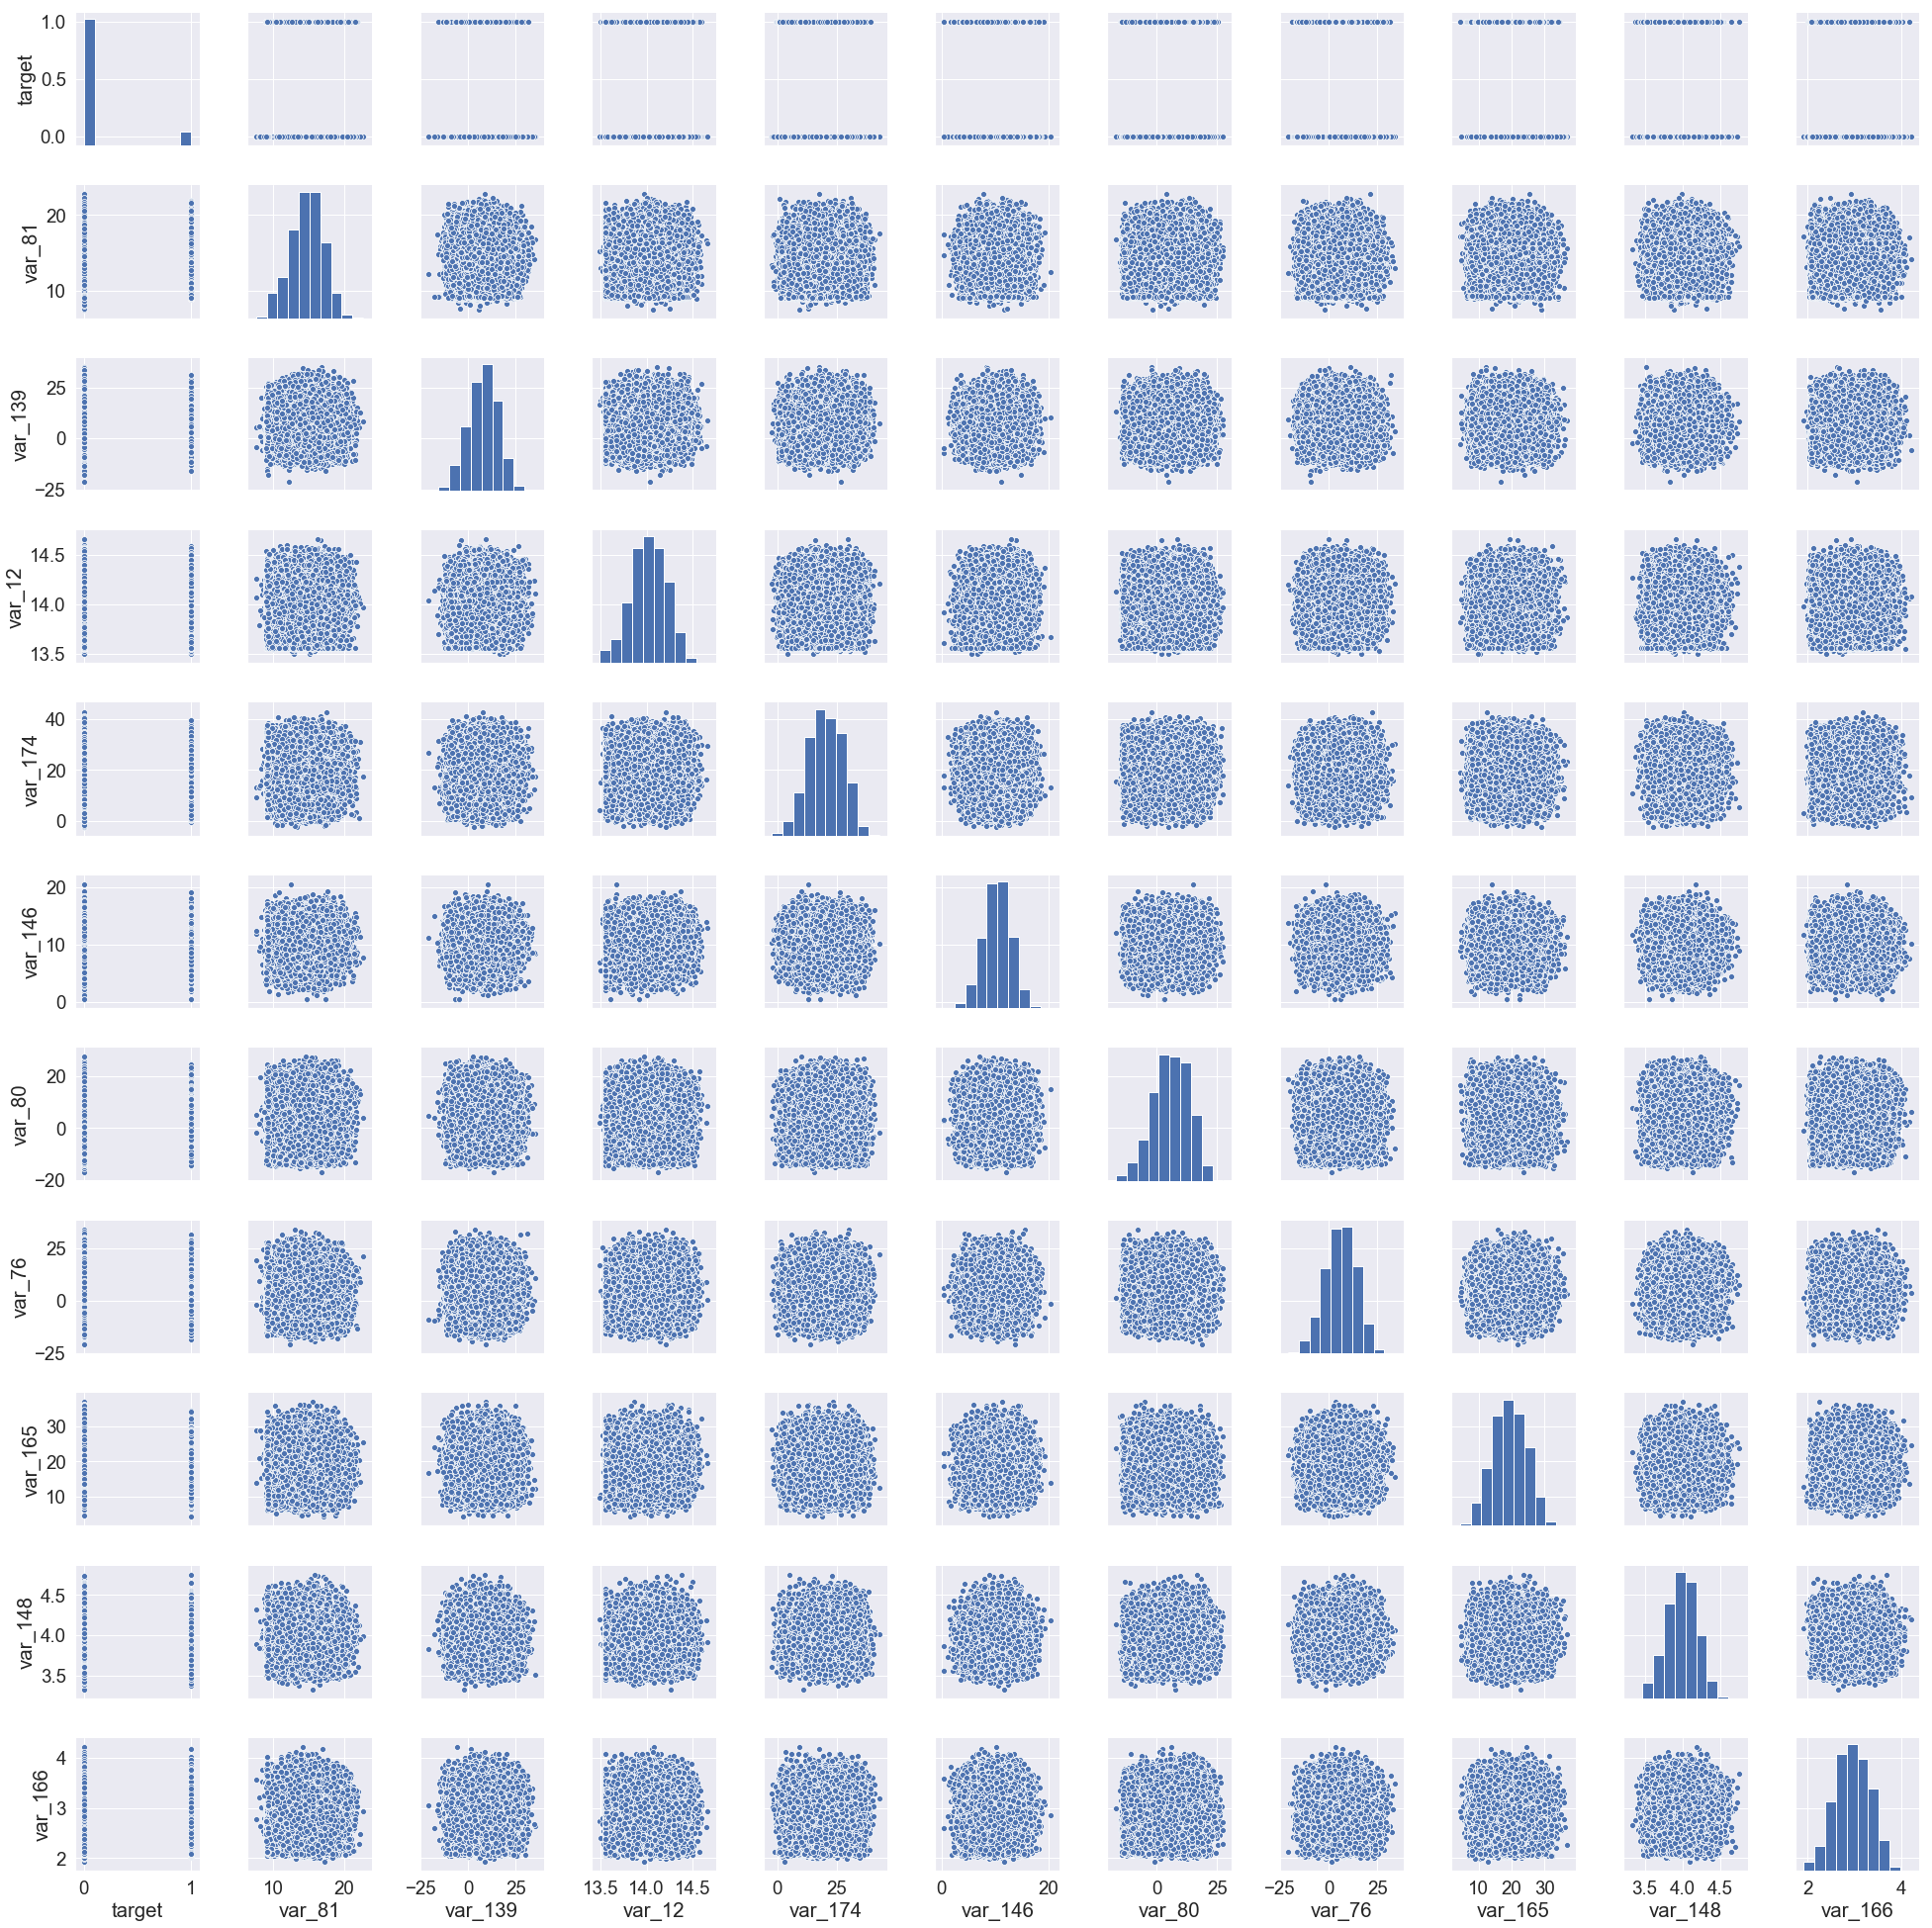

In [11]:
df_pp = df[['target', 'var_81', 'var_139', 'var_12', 'var_174', 
            'var_146', 'var_80', 'var_76', 'var_165', 'var_148', 'var_166']].copy()

sns.set(font_scale=1.7)
sns.pairplot(df_pp)
plt.show()

Nothing too exciting here; looks like a lot of noise.  Features look highly uncorrelated.  We do see that all of these features are very close to normally distributed.  We can also see the previously observed ratio of 1 buy transaction for every 10 transations.  

We can look at a heatmap for the 10 best features (determined above) for a more visual representation of the correlations between target and feature data.

In [12]:
# heatmap
sns.set(font_scale=1.5)
plt.figure(figsize=(15, 7))
corr = df_pp.corr()
corr.style.background_gradient(cmap='coolwarm')

,target,var_81,var_139,var_12,var_174,var_146,var_80,var_76,var_165,var_148,var_166
target,1,-0.0811058,-0.0747927,-0.0635141,-0.0653942,-0.0642619,-0.0601556,-0.0607313,-0.053547,-0.0529157,-0.0546008
var_81,-0.0811058,1,0.00765313,0.00724245,0.0115866,0.00091271,0.00961711,0.00561248,0.00859187,-0.00258189,0.00647109
var_139,-0.0747927,0.00765313,1,-0.00214923,0.0103918,0.00451711,0.00436583,0.00270896,-0.00370258,0.00265054,0.00756882
var_12,-0.0635141,0.00724245,-0.00214923,1,0.00345738,0.0123388,0.00915418,-0.00242927,0.00358927,0.00490492,0.00240943
var_174,-0.0653942,0.0115866,0.0103918,0.00345738,1,0.00112756,-0.00253902,0.00485727,0.00332959,0.00381508,-0.00294691
var_146,-0.0642619,0.00091271,0.00451711,0.0123388,0.00112756,1,0.00658425,-0.00230953,-6.9057e-05,0.0016792,0.00213188
var_80,-0.0601556,0.00961711,0.00436583,0.00915418,-0.00253902,0.00658425,1,0.00172075,0.00498206,0.00577501,0.00755554
var_76,-0.0607313,0.00561248,0.00270896,-0.00242927,0.00485727,-0.00230953,0.00172075,1,-0.00157597,-0.00248378,0.0114176
var_165,-0.053547,0.00859187,-0.00370258,0.00358927,0.00332959,-6.9057e-05,0.00498206,-0.00157597,1,0.00641153,0.00402838
var_148,-0.0529157,-0.00258189,0.00265054,0.00490492,0.00381508,0.0016792,0.00577501,-0.00248378,0.00641153,1,0.004557


<Figure size 1080x504 with 0 Axes>

The above heatmap and correlation values show that there is very little correlation between the target variable and the top 10 best predictive features.  It looks like, at this point, we will need to incorporate many features (maybe most of the 200) to improve the predictive value of each model.

# Build the models and evaluate
The first step to building a good model is to separate the data into training and test data.  We'll train the model on the training data and test it with the test data.  This next line of code breaks the dataframe into 2 dataframes: 1 for training and 1 for test.

In [13]:
# Create training and test sets.
offset = int(df.shape[0] * 0.8)

df_train = df[:offset]
df_test = df[offset:]

Confirm the new shapes of the 2 new dataframes.

In [14]:
df_train.shape

(48000, 201)

In [15]:
df_test.shape

(12000, 201)

Again, confirm the existence of about 10% 'buy' rows for the training data. (8034 is about 10% of 80,000 from above)

In [16]:
print("Customers average buy ratio, {}".format(df['target'].sum()/len(df['target'])))

Customers average buy ratio, 0.10028333333333334


Next, we need to balance the data to account for the current 9 to 1 ratio of 'not buy' to 'buy'.

In [17]:
# set variable buy_num to the total number of buys
buy_num = df_train['target'].sum()
print(buy_num)

# calculate the difference between the total rows and the number of buys
diff = df_train.shape[0] - buy_num

# calculate the number of rows to drop and drop those rows
df_train.drop(df_train.query('target < 1').sample(frac=(1 - (buy_num/diff))).index, inplace=True)
print(df_train.shape)

4823
(9646, 201)


c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Confirm the new shape of the training data.  The new training dataframe has an equal number of 'buy' and 'not buy' rows.  As you can see, the number of rows has twice the number of the number of 'buys' in the dataframe.

In [18]:
print("Number of buys, {}".format(buy_num))
print("Number of rows and columns, {}".format(df_train.shape))

Number of buys, 4823
Number of rows and columns, (9646, 201)


We will use the Area Under the ROC curve insead of the more typical r-squared accuracy measure.  This is the preferred metric in accordance with Kaggle scoring.

Basic Logistic Regression as the first model used to calculate the ROC accuracy.  

In [19]:
# 1.  Logistic Regression

from datetime import datetime
start_time = datetime.now()

# Instantiate our model.
regr = linear_model.LogisticRegression(solver='sag')

# set features and dependent variable for training data
y_train = df_train['target'].values

# drop the 'target' column to obtain the feature inputs
df_train.drop(['target'], axis=1, inplace=True)

# normalize the training data
x_train = sklearn.preprocessing.normalize(df_train)

# now for test...
y_test = df_test['target'].values

# drop the 'target' column to obtain the feature inputs
df_test.drop(['target'], axis=1, inplace=True)

# normalize the test data
x_test = sklearn.preprocessing.normalize(df_test)

# fit model to training data
regr.fit(x_train, y_train)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)



Duration: 0:00:00.972056


In [20]:
from sklearn import metrics
y_test_pred = regr.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.7378780353739826

In [21]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

array([[8019, 2787],
       [ 318,  876]], dtype=int64)

**Evaluation**:  ROC score = 0.738.  Confusion Matrix accruacy = 0.741 (This is calculated by adding the true positive and true negative values of 8019 and 876 and dividing by the total count of 12,000).  We need to remember that the floor predictive value is 0.50 since we know that there only 2 possible outcomes, 0 or 1.  This is a good start; let's see if we can improve upon these accuracy measures.

In [22]:
# 2.  Extra Trees Classifier

from datetime import datetime
start_time = datetime.now()

from sklearn.ensemble import ExtraTreesClassifier

# Instantiate our model.
etc = ExtraTreesClassifier(n_estimators=500)

# fit model to data
etc.fit(x_train, y_train)

from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Duration: 0:00:22.866308


In [23]:
from sklearn import metrics
y_test_pred = etc.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.7588432631415452

In [24]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

array([[8454, 2352],
       [ 316,  878]], dtype=int64)

**Evaluation**:  Scores are a little better.  From sklearn: Extra Trees - "An extremely randomized tree classifier."

"Extra-trees differ from classic decision trees in the way they are built. When looking for the best split to separate the samples of a node into two groups, random splits are drawn for each of the max_features randomly selected features and the best split among those is chosen. When max_features is set 1, this amounts to building a totally random decision tree."

In [25]:
# 3.  Random Forest Classifier

from datetime import datetime
start_time = datetime.now()

from sklearn.ensemble import RandomForestClassifier

# Instantiate our model.
rfc = RandomForestClassifier(n_estimators=500)

# fit model to data
rfc.fit(x_train, y_train)

#------------------------------------------------------------------------------
sfm = SelectFromModel(rfc, threshold=0.001, max_features=10)
sfm.fit(x_train, y_train)
sfm.get_support()
selected_feat = df_train.columns[(sfm.get_support())]
len(selected_feat)
print(selected_feat)
#selected_feat(sfm.estimator_, feature_importances_).ravel().hist()
#------------------------------------------------------------------------------

feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = df_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

Index(['var_6', 'var_22', 'var_53', 'var_81', 'var_99', 'var_110', 'var_139',
       'var_146', 'var_174', 'var_179'],
      dtype='object')

Duration: 0:03:27.607875


Printing the most imprtant features as determined by the random forest algorithm.

In [26]:
print((feature_importances).head(10))

         importance
var_81     0.016546
var_139    0.014266
var_22     0.010545
var_99     0.010472
var_174    0.010045
var_6      0.009553
var_53     0.009442
var_179    0.009365
var_80     0.009124
var_190    0.008929


In [27]:
from sklearn import metrics
y_test_pred = rfc.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.7571412494640517

In [28]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

array([[7838, 2968],
       [ 252,  942]], dtype=int64)

**Evaluation**:  Very similar performance as Extra Trees.  Since a there are so many features and none have a high correlation with the target, we need a lot of 'weak' predictions and then average those to form the final prediction score.

In [29]:
# 4.  Gradient Boosting Classifier

from datetime import datetime
start_time = datetime.now()

from sklearn.ensemble import GradientBoostingClassifier

# Instantiate our model.
gbc = GradientBoostingClassifier(n_estimators=500)

# fit model to data
gbc.fit(x_train, y_train)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Duration: 0:02:02.524008


In [30]:
from sklearn import metrics
y_test_pred = gbc.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.7787007869255588

In [31]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

array([[8494, 2312],
       [ 273,  921]], dtype=int64)

**Evaluation**:  All scores are still a little better than the previous.

The following gradient boosting algorithm is used with just the 10 best features (from Random Forest 'feature_selections_').

In [32]:
# 5.  GBC with just the 10 best features (n_estimators=500)

from datetime import datetime
start_time = datetime.now()

from sklearn.ensemble import GradientBoostingClassifier

# Instantiate our model.
gbc_10 = GradientBoostingClassifier(n_estimators=500)

x_train_10 = sklearn.preprocessing.normalize(df_train[['var_6', 'var_12', 'var_22', 'var_26', 'var_53', 'var_76', 'var_81', 
                    'var_110', 'var_139', 'var_146']])

x_test_10 = sklearn.preprocessing.normalize(df_test[['var_6', 'var_12', 'var_22', 'var_26', 'var_53', 'var_76', 'var_81', 
                                              'var_110', 'var_139', 'var_146']])

# fit model to data
gbc_10.fit(x_train_10, y_train)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Duration: 0:00:07.531431


In [33]:
from sklearn import metrics
y_test_pred = gbc_10.predict(x_test_10)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.6250405739599348

In [34]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

array([[7137, 3669],
       [ 490,  704]], dtype=int64)

**Evaluation**:  Scores are not as good here.  As we see here and will see again later, a model with fewer features performs poorly with this dataset -- again, probably due to the fact that there are no features that correlate highly with the target feature.

In [35]:
# 6.  Support Vector Classifier

from datetime import datetime
start_time = datetime.now()

from sklearn.svm import SVC

# Instantiate our model.
sv_c = SVC(gamma='auto')

# fit model to data
sv_c.fit(x_train, y_train)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Duration: 0:00:34.352965


In [36]:
from sklearn import metrics
y_test_pred = sv_c.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.6690908735794465

In [37]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

array([[7546, 3260],
       [ 430,  764]], dtype=int64)

**Evaluation**:  All scores are ok.  Not as good as some of the others.

In [38]:
# 7.  Voting Classifier with LR, RFC, and NB

from datetime import datetime
start_time = datetime.now()

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import Ridge

clf1 = LogisticRegression(solver='sag')
clf2 = RandomForestClassifier(n_estimators=500)
clf3 = GaussianNB()
clf4 = GradientBoostingClassifier(n_estimators=500)
clf5 = SVC(gamma='auto')
#clf6 = linear_model.Lasso(alpha=.00001)
#clf7 = Ridge(alpha=.00001)

vote = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('gbc', clf4), 
                                    ('svc', clf5)], voting='hard')

vote.fit(x_train, y_train)

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Duration: 0:04:31.966555


In [39]:
from sklearn import metrics
y_test_pred = vote.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.780415123926127

In [40]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

array([[8522, 2284],
       [ 272,  922]], dtype=int64)

**Evaluation**:  All scores are very good.  This ensemble method produced the best results (so far).  There are so many low correlated features, that we need to use many different techniques to extract value.

In [41]:
# 8.  Naive Bayes Bernoulli Classifier

from datetime import datetime
start_time = datetime.now()

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(x_train, y_train)

print('\nR-squared (training):')
print(bnb.score(x_train, y_train))
print('\nR-squared (test):')
print(bnb.score(x_test, y_test))



R-squared (training):
0.6549865229110512

R-squared (test):
0.6645


In [42]:
from sklearn import metrics
y_test_pred = bnb.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.648329096900382

In [43]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

array([[7224, 3582],
       [ 444,  750]], dtype=int64)

**Evaluation**:  All scores are not great.  Bernoulli works better with categorical features and target.  In this case, we have continuous features with a binary (categorical) target.

Now, Bernoulli NB with just the 10 best features.

In [44]:
# 9.  Naive Bayes Bernoulli Classifier with just 10 best features

from datetime import datetime
start_time = datetime.now()

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb_10 = BernoulliNB()

# Fit our model to the data.
bnb_10.fit(x_train_10, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [45]:
from sklearn import metrics
y_test_pred = bnb_10.predict(x_test_10)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.566802176717383

In [46]:
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None)

array([[5815, 4991],
       [ 483,  711]], dtype=int64)

**Evaluation**:  As expected, not so good again.  With less features to draw from, we see a weaker result.

In [47]:
# 10.  Lasso

from datetime import datetime
start_time = datetime.now()

# Instantiate our model and store it in a new variable.
lass = linear_model.Lasso(alpha=.0000001)

# Fit our model to the data.
lass.fit(x_train, y_train)

# print(lass.coef_)
# print(lass.sparse_coef_)

Lasso(alpha=1e-07, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [48]:
from sklearn import metrics
y_test_pred = lass.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.8588489675225409

**Evaluation**:  Surprisingly very, very, good here.  Lasso converts some of the features to 0 (depending on the alpha value) and leaves the most relevant features.  By shrinking some of the features to zero, we can remove some of the noise in the data.  

The solve time for this method is almost instantaneous which is another great feature of this model.  Lasso yielded the best performance for our metric of concern:  area under the ROC curve.

In [49]:
# 10.  Ridge

from datetime import datetime
start_time = datetime.now()

from sklearn.linear_model import Ridge

# Instantiate our model and store it in a new variable.
ridg = Ridge(alpha=.00001)

# Fit our model to the data.
ridg.fit(x_train, y_train)

Ridge(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [50]:
from sklearn import metrics
y_test_pred = ridg.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.8588614458559687

**Evaluation**:  Very good results for Ridge - just as good as Lasso.  These last 2 models are the best predictors for this dataset studied so far.

## Conclusion and discussion
First of all, the number of rows dropped (140,000) definitely has an impact on the performance of each model.  Another significant influence to model accuracy (area under the ROC curve) was the number of 'n_estimators' used in the random forest, extra tree classifier and gradient boosting classifier.  Using 100 n_estimators achieved better results than 10 and 500 got better results than 100; however, the higher this number, the higher the solve times.  There is definitely a trade off.  

Using just the 10 best features was a quick way to test to see if eliminating some noise in the data could yield better results.  These test results did not produce better results; they were worse.  It seems that eliminating some of the weaker correlated features could produce better accuracy measures, but which ones to eliminate (out of the 200) is a tricky question.  More study is needed.  

The results for all 11 models (in decreasing AUC ROC performance) are as follows:
- Lasso and Ridge: 0.859
- Voting Classifier with LR, RFC, NB, GBC and SVC:  0.780
- Gradient Boosting Classifier:  0.779
- Extra Tree Classifier:  0.759
- Random Forest Classifier:  0.757
- Logistic Regression:  0.738
- Support Vector Classifier:  0.669
- Bernoulli Naive Bayes:  0.648
- Graient Boosting with 10 features:  0.625
- Bernoulli NB with 10 features:  0.567  

The results for 9 models in decreasing accuracy from the Confusion Matrix:
- Voting Classifier with LR, RFC, NB, GBC and SVC:  0.787
- Gradient Boosting Classifier:  0.785
- Extra Tree Classifier:  0.778
- Logistic Regression:  0.741
- Random Forest Classifier:  0.732
- Support Vector Classifier:  0.692
- Bernoulli Naive Bayes:  0.665
- Graient Boosting with 10 features:  0.601
- Bernoulli NB with 10 features:  0.544  

The 2 different evaluation methods are very similar.  Logistic Regression slightly outperformed RFC using the Transfusion Matrix accuracy.  

A major factor in increasing accuracy results was adjusting for class imbalance.  Models that did not make the adjustment were quickly discarded and performed significantly worse - around 10 to 15% worse - than models shown in this study which made the adjustment.  

Overall, the best models were the **Lasso and Ridge** regression models.  They outperfomed the next best model (as measured by area under ROC curve by **7.9%**.  Many more modeling techniques exist and can be studied in the future to compare against the resluts obtained here.  